In [41]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [42]:
__PATH__ = Path().parent
__DATA__ = __PATH__ / 'db'

In [43]:
def load_data(ref:str='hasil hasil belajar', type:str='xlsx', sheet:int=2) -> pd.DataFrame :
    """
    
    Fungsi ini mengembalikan data yang dibutuhkan untuk tugas Fuzzy Logic (Rules)
    ref : str 
        Nama file yang akan di load | default : 'hasil hasil belajar.xlsx'
    type : str {'xlsx','csv'}
        Tipe file yang akan di load | default : 'xlsx'
    sheet : int
        Sheet yang akan di load | default : 2
    
    Output : pd.DataFrame
    
    """
    try : 
        if type == 'xlsx' : 
            output = pd.read_excel(__DATA__ / f'{ref}.xlsx', sheet_name=sheet)
        elif type == 'csv' : 
            output = pd.read_csv(__DATA__ / f'{ref}.csv', sheet_name=sheet)
        else : 
            raise ValueError(f'Tipe file {type} tidak dikenal')
    except : 
        raise FileNotFoundError(f'File {ref} tidak ditemukan')
        # print(f'File {ref} tidak ditemukan')
    
    return output 

In [44]:
def triangular_fuzzy(max:float, min:float, mid:float, x:float) -> float:
    """
    Fungsi ini mengembalikan nilai fuzzy dari suatu nilai x
    max : float
        Batas atas
    min : float
        Batas bawah
    mid : float
        Nilai tengah
    x : float
        Nilai x yang akan dihitung
        
    Output : float
    """
    if x <= min : 
        return 0
    elif x <= mid : 
        return (x - min) / (mid - min)
    elif x <= max : 
        return (max - x) / (max - mid)
    else : 
        return 0


def trapezoidal_fuzzy(max:float, min:float, mid1:float, mid2:float, x:float, type:str) -> float:
    """
    Fungsi ini mengembalikan nilai fuzzy dari suatu nilai x
    max : float
        Batas atas
    min : float
        Batas bawah
    mid1 : float
        Nilai tengah 1
    mid2 : float
        Nilai tengah 2
    x : float
        Nilai x yang akan dihitung
    type : str {'left','right'}
        Tipe trapesium yang akan dihitung
        
    Output : float
    """
    if type == 'left' : 
        if x <= min : 
            return 1
        elif x <= mid1 : 
            return (x - min) / (mid1 - min)
        elif x <= mid2 : 
            return 1
        elif x <= max : 
            return (max - x) / (max - mid2)
        else : 
            return 0
    elif type == 'right' : 
        if x <= min : 
            return 0
        elif x <= mid1 : 
            return (x - min) / (mid1 - min)
        elif x <= mid2 : 
            return 1
        elif x <= max : 
            return (max - x) / (max - mid2)
        else : 
            return 1
    else : 
        return 0


In [25]:
class DataFuzzy:
    def __init__(self, df_name, treshold, domain_width) -> None:
        df_name = df_name or "hasil hasil belajar"
        self.treshold = treshold
        self.domain_width = domain_width
        df1 = load_data(df_name, sheet=0)
        df2 = load_data(df_name, sheet=1)
        self.df = pd.concat([df1,df2], ignore_index=True)
        
        # df1['kesimpulannya'] = df1['kesimpulannya'].apply(lambda x: 0)
        # df1['keyakinan'] = df1['keyakinan'].apply(lambda x: 100-x)
        
        self.df['nilai'] = self.df['nilai'].apply(lambda x: int(x))
        self.findAll()
        self.columns = self.df.columns.to_list()
        self.changeMenitToDetik_Column(['lama_berlatih (min 5, mak 15)'])
        self.load_rules()
        self.Process()
        
    def load_rules(self) -> None:
        df = load_data()
        df = df.drop(columns=['Unnamed: 0'])
        #ubah jadi lulus semua
        for iter1, row in df.iterrows() : 
            if row['lulus'] == 'tidak lulus' : 
                df.loc[iter1, 'kepercayaan'] = 100 - row['kepercayaan']
                df.loc[iter1, 'lulus'] = 'lulus'
        
        #ubah dari angka menjadi kecil, sedang, besar
        for iter1, row in df.iterrows() : 
            if row['kepercayaan'] < 25 : 
                df.loc[iter1, 'kepercayaan'] = 'kecil'
            elif row['kepercayaan'] < 75 : 
                df.loc[iter1, 'kepercayaan'] = 'sedang'
            else : 
                df.loc[iter1, 'kepercayaan'] = 'besar'
        
        self.rules = df
                
    def findMax(self, column:str) -> float:
        return self.df[column].max()
    
    def findMin(self, column:str) -> float:
        return self.df[column].min()
    
    def findAll(self):
        self.findAllMax()
        self.findAllMin()
    
    def findAllMax(self) -> dict:
        self.AllMax = {col:self.findMax(col) for col in self.df.columns}

    def findAllMin(self) -> dict:
        self.AllMin = {col:self.findMin(col) for col in self.df.columns}
    
    def deleteColumns(self, columns:list) -> None:
        self.df.drop(columns=columns, inplace=True)
        
    @staticmethod
    def __menittoDetikconverter(x:str='7 menit, 32 detik') -> int:
        """
        Fungsi ini mengembalikan nilai detik dari suatu string waktu
        x : str
            String waktu dalam format 'menit menit, detik det
        Output : int
        """
        menit, detik = x.split(',')
        menit = int(menit.split(' ')[0])
        detik = int(detik.split(' ')[1])
        return menit*60+detik
    
    def changeMenitToDetik_Column(self, columns:list) -> None:
        for col in columns:
            self.df[col] = self.df[col].apply(lambda x: self.__menittoDetikconverter(x))
        self.findAll()
            
    @staticmethod
    def make_domain(min:int,max:int,amount:int, domain_width:float) -> list:
        """
        Fungsi make_domain digunakan untuk membuat domain fuzzy
        
        min : nilai minimum dari domain fuzzy
        max : nilai maksimum dari domain fuzzy
        amount: jumlah domain fuzzy yang akan dibuat
        
        """
        # print([(min, int(max/2)), (int(max/4), int(int(max/2)+int(max/4))), (int(max/2), max)])
        return [(min, int(max/2) + int(int(max/2)*domain_width)), \
            (int(max/4)+ int(int(max/4)*domain_width), int(int(max/2)+int(max/4))+int(int(int(max/2)+int(max/4))*domain_width)),\
            (int(max/2)+int(int(max/2)*domain_width), max)]
            
    def makeFuzzyDomain(self, exception:list=[]) -> None:
        self.data_fuzzy = {}
        for value in self.columns:
            if(value not in exception):
                try:
                    ans = (self.make_domain(min=int(self.AllMin[value]),max=int(self.AllMax[value]),amount=3, domain_width=self.domain_width))
                    self.data_fuzzy[value] = ans
                except ValueError as e:
                    self.data_fuzzy[value] = None
                
    @staticmethod
    def checkRange(data:dict, title:str, value:int) -> list[int]:
        """
        Fungsi ini mengembalikan index rentang fuzzy dari suatu nilai
        data : dict
            Data fuzzy yang akan di cek
        title : str
            Judul data yang akan di cek
        value : int
            Nilai yang akan di cek
            
        Minus : Belum bisa mencari jika dia berada di 2 rentang bersamaan
            
        Output : list[int]
        """
        ans = []
        # print(data[title][0])
        for idx, (min,max) in enumerate(data[title]):
            if (idx == 0) and (value <= min):
                ans.append(idx)
            elif (idx == len(data[title])-1) and (value >= max):
                ans.append(idx)
            elif value >= min and value <= max:
                ans.append(idx)
        return ans
    
    def showFigure(self) -> None:
        if self.data_fuzzy is None:
            raise ValueError("Data Fuzzy belum dibuat")
        
        if self.AllMax is None or self.AllMin is None:
            raise ValueError("Data Max atau Min belum dibuat")
        
        fig, ax = plt.subplots(1,len(self.data_fuzzy),figsize=(10,2))  
        for key,data in enumerate(self.data_fuzzy):
            for idx, (min,max) in enumerate(self.data_fuzzy[data]):
                # print(min,max)
                if idx == 0:
                    ax[key].plot([min, (max+min)/2, max], [1, 1, 0])
                elif idx == len(self.data_fuzzy[data])-1:
                    ax[key].plot([min, (max+min)/2, max], [0, 1, 1])
                else:
                    ax[key].plot([min, (max+min)/2, max], [0, 1, 0])
                
                ax[key].set_title(f'{data}', fontsize=6)
                ax[key].set_ylabel('Fuzzy Value', fontsize=6)
                
    @staticmethod
    def flatten_list(list_flatten:list) -> list:
        """
        Fungsi flatten_list digunakan untuk meratakan list
        
        list_flatten : list yang akan diratakan
        
        """
        return [item for sublist in list_flatten for item in sublist]

    def Fuzzifikasi(self, exceptions:list[str]) -> dict:
        """"
        
        Fungsi ini digunakan untuk menghitung nilai fuzzy dari suatu data dan mendapatkan derajat keanggotaannya
        
        
        """
        if self.df is None:
            raise ValueError("Data belum di load")
        
        if self.data_fuzzy is None:
            raise ValueError("Data Fuzzy belum dibuat")
        
        self.hasilFuzzy = None
        all_result = []

        for key,value in self.df.iterrows():
            result = {}
            for idx, data in value.items():
                if (idx not in exceptions):
                    ans = []
                    selected = self.checkRange(self.data_fuzzy, idx, data)
                    for num in selected:
                        maks = self.data_fuzzy[idx][num][1]
                        minn = self.data_fuzzy[idx][num][0]
                        if num == 0: #kalo di anggota kiri (trapezoidal kiri)
                            ans.append(trapezoidal_fuzzy(min=minn, mid1=minn, mid2=(maks+minn)/2, max=maks, x=data, type='left'))
                            # ans.append(triangular_fuzzy(min=(maks+minn)/2, mid=(maks+minn)/2, max=maks, x=data))
                        elif num == len(self.data_fuzzy[idx])-1: #kalo di anggota kanan (trapezoidal kanan)
                            ans.append(trapezoidal_fuzzy(min=minn, mid1=(maks+minn)/2, mid2=maks, max=maks, x=data, type='right'))
                            # ans.append(triangular_fuzzy(min=minn, mid=minn, max=maks, x=data))
                        else: #kalo di anggota tengah (triangular)
                            ans.append(triangular_fuzzy(min=minn, mid=(maks+minn)/2, max=maks, x=data))
                    result[idx] = selected, ans
                
            all_result.append(result)
            
        self.hasilFuzzy = all_result
        return all_result

    def showFuzzyResult(self, idx:int) -> None:
        """
        
        Fungsi ini digunakan untuk menampilkan hasil fuzzy dari suatu data
        idx : int
            Index data yang ingin ditampilkan
        
        """
        if self.hasilFuzzy is None:
            raise ValueError("Data Fuzzy belum dihitung")
        if idx >= len(self.hasilFuzzy):
            raise ValueError("Index yang diinput melebihi jumlah data")
        
        for key,value in self.hasilFuzzy[idx].items():
            print(key,value)
            
    @staticmethod
    def findCombination(data:list) -> list:
        """
        Fungsi ini mengembalikan semua kombinasi dari suatu list untuk fuzzy
        data : list
            List yang isinya list dari data yang ingin dicari
            
        Output : list
        """
        
        all_count = [0 for _ in range(len(data))]
        prob = 1
        for i in all_count:
            prob *= len(data[i])
        all_comb = []
        for _ in range(prob):
            temp = []
            try :
                for idx,value in enumerate(all_count):
                    temp.append(data[idx][value])
                if temp not in all_comb:
                    all_comb.append(temp)
                    
                all_count[-1] += 1
                for i in range(len(all_count)-1,-1,-1):
                    if all_count[i] == len(data[i]):
                        all_count[i] = 0
                        all_count[i-1] += 1
            except:
                break                
        return all_comb
   
    @staticmethod
    def applyRules(data:list, rules:pd.DataFrame, value:float) -> list:
        """
        
        Fungsi ini digunakan untuk mencocokkan rules pada data fuzzy (satu data)
        data : list
            List data fuzzy yang akan di cek
        rules : pd.DataFrame
            Data rules yang akan di cek
        value : float
            Derajat keanggotaan dari data fuzzy
        
        """
        for key,rule in rules.iterrows():
            if(data == [rule[0], rule[1], rule[2]]): 
                return [(rule.iloc[-2], rule.iloc[-1])]
                
   
    def Inference(self) -> None:
        """
        
        Fungsi ini digunakan untuk memproses data fuzzy yang sudah dihitung, dan mencari hasil inferensi
        
        """
        if self.hasilFuzzy is None:
            raise ValueError("Data Fuzzy belum dihitung")
        
        #Mencari alpha predikat dari tiap data
        all_alphapredikat = []
        for value in self.hasilFuzzy:
            result = []
            for idx, data in value.items():
                result.append(data[0])
                
            ans = self.findCombination((result))
            all_combi = []
            for search in ans:
                smallestValue = value[list(value.keys())[0]][1][value[list(value.keys())[0]][0].index(search[0])]
                for key,(idx, data) in enumerate(value.items()):
                    try:
                        smallestValue = min(smallestValue, data[1][data[0].index(search[key])])
                    except:
                        pass
                    # print(data[1][search[idx]])
                all_combi.append((search, smallestValue))
            
            all_alphapredikat.append(all_combi)
            
        mapping = {
            0 : 'kecil',
            1 : 'sedang',
            2 : 'besar'
        }
        
        self.alphapredikat = all_alphapredikat
        
        inferenced_result = [] 
        #cari max agregasi rendah, sedang, besar dari semua data
        for data in all_alphapredikat:
            best = {
                'kecil' : 0,
                'sedang' : 0,
                'besar' : 0
            }
            for combination,value in data:
                mapped_value = [mapping[value] for value in combination]
                result = self.applyRules(mapped_value, self.rules, value)
                for idx in range(len(result)):
                    best[result[idx][1]] = max(best[result[idx][1]], value)
            inferenced_result.append(best)
        self.InferenceResult = inferenced_result
    
    @staticmethod
    def calculate_coa(row, labels, ranges):
        """
        Menghitung Center of Area (COA) untuk baris dalam DataFrame output agregat.

        Args:
        row: Baris dari DataFrame output agregat.
        labels: Label dari himpunan fuzzy.
        ranges: Kamus rentang untuk setiap himpunan fuzzy.

        Returns:
        Center of Area (COA) untuk baris tersebut.
        """
        numerator = 0
        denominator = 0
        for label in labels:
            a, b, c = ranges[label]
            # Hitung pusat segitiga
            center = (a + b + c) / 3
            # Hitung luas segitiga
            area = 0.5 * (c - a) * row[label]
            numerator += center * area
            denominator += area
        if denominator == 0:
            return 0
        return numerator / denominator
            
    def defuzzification(self) -> None:
        """
        
        Fungsi ini digunakan untuk mendefuzzifikasi hasil inferensi
        
        """
        if self.InferenceResult is None:
            raise ValueError("Data Inference belum dihitung")
        
        all_result = []
        for value in self.InferenceResult:
            result = self.calculate_coa(value, ['kecil', 'sedang', 'besar'], {
                'kecil': (0, 0, 25),
                'sedang': (25, 50, 75),
                'besar': (75, 100, 100)
            })
            all_result.append(result)
        
        self.defuzzification_result = all_result
        
    def predict(self) -> list:
        if self.defuzzification_result is None:
            raise ValueError("Data defuzzifikasi belum dihitung")
        
        return ['tidak lulus' if value < self.treshold else 'lulus' for value in self.defuzzification_result]
    
    def ConfusionMatrix(self, hasil_count:dict) -> plt:
        """
        
        Fungsi ini menampilkan confusion matrix dari hasil akurasi

        
        """
        plt.figure(figsize=(4,4))
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.imshow([[hasil_count['lulus (TP)'],hasil_count['lulus (FP)']],[hasil_count['tidak lulus (FP)'],hasil_count['tidak lulus (TP)']]])
        plt.colorbar()
        plt.xticks([0,1],['lulus','tidak lulus'])
        plt.yticks([0,1],['lulus','tidak lulus'])
        plt.show()
        
        
    def showAccuracy(self, output=False) -> None:
        """
        
        Fungsi ini digunakan untuk menampilkan akurasi dari hasil inferensi
        Accuracy = (Jumlah data yang benar / Jumlah data) * 100%
        
        """
        if self.defuzzification_result is None:
            raise ValueError("Data defuzzifikasi belum dihitung")
        
        predicted = self.predict()
        
        hasil_count = {
            "tidak lulus (TP)" : 0,
            "lulus (TP)" : 0,
            "tidak lulus (FP)" : 0,
            "lulus (FP)" : 0
        }
        
        count = 0
        maps = {
            0 : 'tidak lulus',
            1 : 'lulus'
        }
        for key,value in enumerate(predicted):
            real =  maps[self.df.loc[key, 'kesimpulannya']]
            if real == value:
                count += 1
                hasil_count[f"{real} (TP)"] += 1
            else:
                hasil_count[f"{real} (FP)"] += 1
                
                
        if output:
            self.ConfusionMatrix(hasil_count)
            print(f"Accuracy : {count/len(self.defuzzification_result)*100:.2f}%")
        return count/len(self.defuzzification_result)*100
        
    def Process(self, FuzzyDomain_ColumnsException:list[str]=['no','kesimpulannya','keyakinan']) -> None:
        self.makeFuzzyDomain(exception=FuzzyDomain_ColumnsException)
        self.Fuzzifikasi(exceptions=FuzzyDomain_ColumnsException)
        self.Inference()
        self.defuzzification()
        self.showAccuracy() 
        
    @staticmethod    
    def optimization_graph(x:list,y:list, xlabel:str, ylabel:str):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(x,y)  
        xlabel = xlabel or 'Domain Range'
        ylabel = ylabel or 'Accuracy'
        # ax.set_xticks(x)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title('Optimization Graph')
        plt.show()
        
    def optimation(self, treshold:list[int], domain_width:list[float]) -> None:
        x,y=[],[]
        bestFit = None
        iteration = 0
        for i in tqdm(range(0,len(treshold)), desc='Predicting'):
        # for data in treshold:
            for j in range(0,len(domain_width)):
                iteration += 1
                self.domain_width = domain_width[j]
                self.treshold = treshold[i]
                self.Inference()
                x.append(iteration)
                y.append(self.showAccuracy())
                if bestFit is None:
                    bestFit = ((treshold[i], domain_width[j]),self.showAccuracy())
                elif bestFit[1] < self.showAccuracy():
                    bestFit = ((treshold[i], domain_width[j]),self.showAccuracy())
        print(f"x : {x}, y : {y}")
        self.optimization_graph(x,y,xlabel='iteration', ylabel='Accuracy')
        self.bestFit = bestFit
        print(f"Best Fit : {bestFit}")
        

In [26]:
class PSO (DataFuzzy):
    """
    Particle Swarm Optimization
    
    """
    def __init__(self, treshold, domain_width):
        super().__init__('hasil hasil belajar',treshold=treshold, domain_width=domain_width)
        self.gbest = None
        
    def fitness(self, x, y):
        self.treshold = x
        self.domain_width = y
        self.Process()
        return self.showAccuracy() 

    def train(self, n_particles, n_iter, w=0.5, c1=1, c2=1):
        """
        Particle Swarm Optimization
        
        n_particles : int
            Jumlah partikel
        n_iter : int
            Jumlah iterasi
        w : float
            Inertia weight
        c1 : float
            Cognitive weight
        c2 : float
            Social weight
        
        """
        class Particle:
            def __init__(self, treshold, domain_width):
                self.treshold = treshold
                self.domain_width = domain_width
                self.pbest = (treshold, domain_width)
                self.pbest_score = -1
                self.velocity = [0,0]
                
        x,y = [],[]
        gbest = None
        CallbackCount = 0
        particles = [Particle(np.random.randint(0,100), np.random.rand()) for _ in range(n_particles)]
        for i in tqdm(range(n_iter), desc='PSO'):
            for particle in particles:
                score = self.fitness(particle.treshold, particle.domain_width)
                if score > particle.pbest_score:
                    particle.pbest_score = score
                    particle.pbest = (particle.treshold, particle.domain_width)
                if gbest is None or score > gbest[1]:
                    gbest = (particle.treshold, particle.domain_width), score
                print(f"Particle : {particle.treshold}, {particle.domain_width}, Score : {score}")
            
            CallbackCount += 1 if score == gbest[1] else 0
            if CallbackCount >= 5:
                print(f"Callbacks reached. Stopping...")
                break
            x.append(i+1)
            y.append(gbest[1])
            
            for particle in particles:
                r1 = np.random.rand()
                r2 = np.random.rand()
                particle.velocity[0] = w * particle.velocity[0] + c1 * r1 * (particle.pbest[0] - particle.treshold) + c2 * r2 * (gbest[0][0] - particle.treshold)
                particle.treshold += particle.velocity[0]
                particle.treshold = max(0, particle.treshold)
                particle.treshold = min(100, particle.treshold)
                
                r1 = np.random.rand()
                r2 = np.random.rand()
                particle.velocity[1] = w * particle.velocity[1] + c1 * r1 * (particle.pbest[1] - particle.domain_width) + c2 * r2 * (gbest[0][1] - particle.domain_width)
                particle.domain_width += particle.velocity[1]
                particle.domain_width = max(0, particle.domain_width)
                particle.domain_width = min(1, particle.domain_width)
                
                randomNum = np.random.rand()
                if randomNum < 0.1:
                    particle.treshold = np.random.randint(0,100)
                    particle.domain_width = np.random.rand()
        print(f"Best Fit : {gbest}")
        self.optimization_graph(x,y, xlabel='iteration', ylabel='Accuracy')
        self.gbest = gbest
        return gbest
        
    def __repr__(self):
        return f"Treshold : {self.treshold}\n Domain Width : {self.domain_width}, Best Fit : {self.gbest}"
        
    

In [27]:
data = DataFuzzy('hasil hasil belajar', 45, 0.01)

C:\Users\Windows\AppData\Local\Temp\ipykernel_79532\4176031106.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'kecil' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[iter1, 'kepercayaan'] = 'kecil'
C:\Users\Windows\AppData\Local\Temp\ipykernel_79532\4176031106.py:261: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(data == [rule[0], rule[1], rule[2]]):


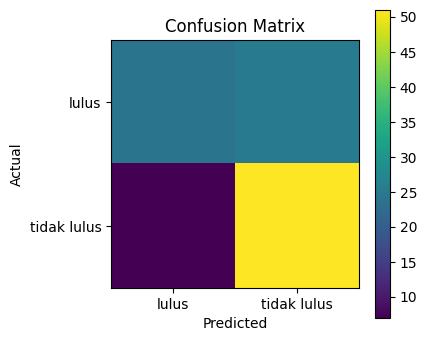

Accuracy : 70.09%


70.09345794392523

In [28]:
data.showAccuracy(output=True)

In [29]:
data1 = PSO(50, 0.01)

C:\Users\Windows\AppData\Local\Temp\ipykernel_79532\4176031106.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'kecil' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[iter1, 'kepercayaan'] = 'kecil'
C:\Users\Windows\AppData\Local\Temp\ipykernel_79532\4176031106.py:261: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(data == [rule[0], rule[1], rule[2]]):


PSO:   0%|          | 0/250 [00:00<?, ?it/s]C:\Users\Windows\AppData\Local\Temp\ipykernel_79532\4176031106.py:261: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(data == [rule[0], rule[1], rule[2]]):


Particle : 17, 0.30017999464206635, Score : 70.09345794392523
Particle : 47, 0.993665518792562, Score : 53.271028037383175
Particle : 3, 0.38193339288704675, Score : 45.794392523364486


PSO:   0%|          | 1/250 [00:00<03:18,  1.25it/s]

Particle : 69, 0.9615677890477357, Score : 54.20560747663551
Particle : 91, 0.8792857361150457, Score : 54.20560747663551
Particle : 17.0, 0.30017999464206635, Score : 70.09345794392523
Particle : 33.184640697970394, 0.4846586277535423, Score : 56.074766355140184
Particle : 6.8707102811639915, 0.3171954835632075, Score : 45.794392523364486


PSO:   1%|          | 2/250 [00:01<03:32,  1.17it/s]

Particle : 57.29047642221873, 0.8120394911801253, Score : 53.271028037383175
Particle : 97, 0.6034082913283868, Score : 54.20560747663551
Particle : 17.0, 0.30017999464206635, Score : 70.09345794392523
Particle : 13.555364656126741, 0.20292597271939306, Score : 70.09345794392523
Particle : 11.10237876504426, 0.33513044523292834, Score : 71.02803738317756
Particle : 46, 0.9054629039167703, Score : 53.271028037383175
Particle : 22.96790787104382, 0.3059335343717504, Score : 70.09345794392523


PSO:   1%|          | 3/250 [00:02<03:54,  1.06it/s]

Particle : 13.097587552816865, 0.32554195163803074, Score : 70.09345794392523
Particle : 1.761498443302962, 0.16157458047318618, Score : 45.794392523364486


PSO:   2%|▏         | 4/250 [00:03<04:01,  1.02it/s]

Particle : 13.218213006984396, 0.3440979260677888, Score : 71.02803738317756
Particle : 44.66649488866504, 0.48486142659749104, Score : 53.271028037383175
Particle : 0, 0.1793811567663936, Score : 45.794392523364486
Particle : 12.971557823445417, 0.3280733233504977, Score : 70.09345794392523
Particle : 9.748130942511619, 0.3274061437397238, Score : 71.96261682242991
Particle : 12.061086172651564, 0.34546589494887847, Score : 71.02803738317756
Particle : 35.606850777695506, 0.4720278078122097, Score : 55.140186915887845


PSO:   2%|▏         | 5/250 [00:04<04:13,  1.04s/it]

Particle : 9.10461558169499, 0.21342423648838857, Score : 69.1588785046729
Particle : 14.990307533639196, 0.31817641766370786, Score : 70.09345794392523
Particle : 13.741447192115947, 0.4103219253729926, Score : 70.09345794392523
Particle : 9.946104485807137, 0.3296200972363485, Score : 70.09345794392523
Particle : 26.591759869425758, 0.36601404483987476, Score : 67.28971962616822


PSO:   2%|▏         | 6/250 [00:06<04:19,  1.06s/it]

Particle : 67, 0.3186443771943859, Score : 53.271028037383175
Particle : 15.097688448001152, 0.31774729000792523, Score : 70.09345794392523
Particle : 25, 0.08860954683290478, Score : 72.89719626168224
Particle : 31, 0.24891284787639711, Score : 69.1588785046729
Particle : 17.913334760661908, 0.2920646989595814, Score : 68.22429906542055


PSO:   3%|▎         | 7/250 [00:07<04:19,  1.07s/it]

Particle : 16.96735802552591, 0.3880999000471286, Score : 70.09345794392523
Particle : 25.99429451123241, 0.27101331308791216, Score : 70.09345794392523
Particle : 22.753323131411634, 0.038099592119553306, Score : 76.63551401869158
Particle : 7.264859482203757, 0.20277605004184807, Score : 45.794392523364486
Particle : 15.995589317779233, 0.08702743597192397, Score : 74.76635514018692


PSO:   3%|▎         | 8/250 [00:08<04:17,  1.06s/it]

Particle : 2.493658837781613, 0.14392366721479813, Score : 45.794392523364486
Particle : 26.679206571505972, 0.1105029367560234, Score : 68.22429906542055
Particle : 21.62998469711745, 0.012844614762877567, Score : 78.50467289719626
Particle : 11.531144587744683, 0.07384013750559534, Score : 76.63551401869158


PSO:   4%|▎         | 9/250 [00:09<04:08,  1.03s/it]

Particle : 20.542977370943547, 0, Score : 78.50467289719626
Particle : 18.956465831853897, 0.04046645942124981, Score : 77.57009345794393
Particle : 24.600716745128597, 0.0811758507467927, Score : 74.76635514018692


PSO:   4%|▍         | 10/250 [00:10<03:58,  1.01it/s]

Particle : 21.06831547997036, 0.00021712608453969794, Score : 79.43925233644859
Particle : 23.11372765138129, 0, Score : 78.50467289719626
Particle : 23.08381398544502, 0, Score : 78.50467289719626
Particle : 29.37408039181724, 0, Score : 77.57009345794393
Particle : 20.50985937658686, 0.00042873155527001217, Score : 78.50467289719626
Particle : 20.787480871396813, 0, Score : 78.50467289719626
Particle : 27.821321173009565, 0, Score : 77.57009345794393


PSO:   4%|▍         | 11/250 [00:10<03:48,  1.04it/s]

Particle : 21.552200889019623, 0, Score : 79.43925233644859
Particle : 29.734650057162792, 0, Score : 77.57009345794393
Particle : 18.669928910027178, 0, Score : 76.63551401869158
Particle : 20.80796623201846, 0, Score : 78.50467289719626
Particle : 21.259876051572213, 0, Score : 79.43925233644859
Particle : 20.629739773008716, 0, Score : 78.50467289719626
Particle : 24.902507987252076, 0.02137780211482097, Score : 77.57009345794393


PSO:   5%|▍         | 12/250 [00:11<03:36,  1.10it/s]

Particle : 20.296160792719917, 0, Score : 78.50467289719626
Particle : 20.920068372411922, 0, Score : 78.50467289719626


PSO:   5%|▌         | 13/250 [00:12<03:28,  1.14it/s]

Particle : 17.931220554670958, 0, Score : 77.57009345794393
Particle : 21.02952526339806, 0, Score : 78.50467289719626
Particle : 13.1015668182873, 0.04607428061772627, Score : 77.57009345794393
Particle : 21.54076240904208, 0, Score : 79.43925233644859
Particle : 21.171568281458683, 0, Score : 79.43925233644859
Particle : 19.737086546633513, 0, Score : 77.57009345794393
Particle : 21.440145578286394, 0, Score : 79.43925233644859


PSO:   6%|▌         | 14/250 [00:13<03:23,  1.16it/s]

Particle : 11.452982440303398, 0.017202792841770738, Score : 76.63551401869158
Particle : 21.83096015616097, 0, Score : 79.43925233644859
Particle : 21.26084678269504, 2.3846265074465174e-05, Score : 79.43925233644859


PSO:   6%|▌         | 15/250 [00:14<03:19,  1.18it/s]

Particle : 21.72329028854514, 0, Score : 79.43925233644859
Particle : 21.45240019394762, 0, Score : 79.43925233644859
Particle : 18.515447254800016, 0.019057997056274166, Score : 78.50467289719626
Particle : 21.3896803551392, 0, Score : 79.43925233644859
Particle : 21.11904154630135, 0.00029627888256824773, Score : 79.43925233644859
Particle : 21.764044195447163, 0, Score : 79.43925233644859
Particle : 21.242775375461335, 0, Score : 79.43925233644859


PSO:   6%|▋         | 16/250 [00:14<03:15,  1.19it/s]

Particle : 22.949710404282982, 0.014599864587768106, Score : 78.50467289719626
Particle : 21.102337916262172, 0, Score : 79.43925233644859
Particle : 21.02554506256866, 0.0003726652437804591, Score : 78.50467289719626


PSO:   7%|▋         | 17/250 [00:15<03:17,  1.18it/s]

Particle : 20.911023441138195, 0, Score : 78.50467289719626
Particle : 21.346433954323892, 0, Score : 79.43925233644859
Particle : 22.321076795060293, 0.012690522794224756, Score : 78.50467289719626
Particle : 71, 0.050565705974385144, Score : 51.4018691588785
Particle : 20.982514330897096, 0.0002997848916533061, Score : 78.50467289719626


PSO:   7%|▋         | 18/250 [00:16<03:15,  1.19it/s]

Particle : 20.657747524092407, 0, Score : 78.50467289719626
Particle : 21.31908497829861, 3.465365821024997e-06, Score : 79.43925233644859
Particle : 18.555765413576992, 0.004056212362430237, Score : 76.63551401869158
Particle : 27.26340382729287, 0, Score : 77.57009345794393
Particle : 91, 0.5859983755638151, Score : 54.20560747663551


PSO:   8%|▊         | 19/250 [00:17<03:14,  1.19it/s]

Particle : 20.82694182717377, 0, Score : 78.50467289719626
Particle : 21.203624979292535, 4.019209560338449e-05, Score : 79.43925233644859
Particle : 18.72365475315389, 0, Score : 76.63551401869158
Particle : 1.4627349386719324, 0, Score : 46.728971962616825
Particle : 39.45690027958029, 0.14171533965084343, Score : 66.35514018691589
Particle : 21.41598309710268, 9.944874661891684e-05, Score : 79.43925233644859
Particle : 21.35872216094556, 4.746349383917587e-05, Score : 79.43925233644859


PSO:   8%|▊         | 20/250 [00:18<03:12,  1.19it/s]

Particle : 18.783532211869968, 0, Score : 76.63551401869158
Particle : 4.418001705036354, 0, Score : 46.728971962616825
Particle : 0, 0, Score : 45.794392523364486
Particle : 21.46319582987142, 0.00016921238283850858, Score : 79.43925233644859
Particle : 21.454386125429956, 0.0001463244100253731, Score : 79.43925233644859


PSO:   8%|▊         | 21/250 [00:19<03:10,  1.20it/s]

Particle : 19.166686456682182, 0.014109540799532574, Score : 78.50467289719626
Particle : 16.924292790656356, 0, Score : 76.63551401869158


PSO:   9%|▉         | 22/250 [00:20<03:13,  1.18it/s]

Particle : 0.2248228816062472, 0, Score : 46.728971962616825
Particle : 21.45736586249999, 0.00011378244897821306, Score : 79.43925233644859
Particle : 21.517224346851236, 9.075298469441933e-05, Score : 79.43925233644859
Particle : 19.943322461725657, 0.02138215322280853, Score : 79.43925233644859
Particle : 29.59508650310727, 0, Score : 77.57009345794393
Particle : 35.90361286602547, 0, Score : 74.76635514018692
Particle : 21.123065923897812, 4.067661065236917e-05, Score : 79.43925233644859
Particle : 21.296520151499788, 6.071981119073401e-05, Score : 79.43925233644859


PSO:   9%|▉         | 23/250 [00:20<03:06,  1.21it/s]

Particle : 24, 0.8270463104827884, Score : 53.271028037383175
Particle : 21.071224414242547, 0, Score : 79.43925233644859
Particle : 39.15237208700849, 0, Score : 71.96261682242991
Particle : 21.058112801577515, 1.0504420864744347e-06, Score : 78.50467289719626


PSO:  10%|▉         | 24/250 [00:21<03:06,  1.21it/s]

Particle : 21.367358903945085, 0.0001762692021633379, Score : 79.43925233644859
Particle : 20.403970008574095, 0.45341651977819, Score : 66.35514018691589
Particle : 16.819788703171948, 0, Score : 76.63551401869158
Particle : 32.922546535053044, 0, Score : 75.70093457943925
Particle : 21.113267012748288, 0, Score : 79.43925233644859


PSO:  10%|█         | 25/250 [00:22<03:03,  1.22it/s]

Particle : 21.280370307261965, 0.00011783450743001018, Score : 79.43925233644859
Particle : 18.406635068573834, 0, Score : 77.57009345794393
Particle : 52, 0.2549849543529865, Score : 51.4018691588785
Particle : 18.535737059857325, 0, Score : 77.57009345794393
Particle : 21.175611975948172, 0.0002065983853556676, Score : 79.43925233644859


PSO:  10%|█         | 26/250 [00:23<03:05,  1.21it/s]

Particle : 21.274252628819852, 8.4739728715024e-05, Score : 79.43925233644859
Particle : 19.844655982953263, 0, Score : 78.50467289719626


PSO:  11%|█         | 27/250 [00:24<03:03,  1.22it/s]

Particle : 22.179654994939774, 0, Score : 79.43925233644859
Particle : 11.743599403581005, 0, Score : 77.57009345794393
Particle : 21.217959046466525, 0.0002257606992204609, Score : 79.43925233644859
Particle : 21.423252229919683, 7.614666023370877e-05, Score : 79.43925233644859
Particle : 20.638027093273106, 0, Score : 78.50467289719626
Particle : 6.216232222816787, 0, Score : 46.728971962616825
Particle : 14.733006762398386, 0, Score : 75.70093457943925
Particle : 21.222133653121325, 0.00012817413009347277, Score : 79.43925233644859
Particle : 21.25200005612389, 8.517726948298495e-05, Score : 79.43925233644859
Particle : 20.936339722988365, 0, Score : 78.50467289719626


PSO:  11%|█         | 28/250 [00:24<03:00,  1.23it/s]

Particle : 22.03298675851829, 0, Score : 79.43925233644859
Particle : 25.487814428971546, 0, Score : 77.57009345794393


PSO:  12%|█▏        | 29/250 [00:25<02:58,  1.24it/s]

Particle : 21.239278447768015, 3.42589502249163e-05, Score : 79.43925233644859
Particle : 21.233702716774328, 0.00015354439520730528, Score : 79.43925233644859
Particle : 21.067295235433487, 0, Score : 79.43925233644859


PSO:  12%|█▏        | 30/250 [00:26<02:54,  1.26it/s]

Particle : 29.34792381348179, 0, Score : 77.57009345794393
Particle : 28.083630543370024, 0, Score : 77.57009345794393
Particle : 30, 0.841734373431207, Score : 53.271028037383175
Particle : 21.316395733597382, 0.00011083239383201236, Score : 79.43925233644859
Particle : 20.124156684894047, 0.004292750723572931, Score : 78.50467289719626
Particle : 20.31391601161713, 0, Score : 78.50467289719626
Particle : 22.668789018657833, 0.00010084286278231905, Score : 78.50467289719626
Particle : 21.61970246213367, 0, Score : 79.43925233644859
Particle : 21.423409561970733, 0.00014769180102119716, Score : 79.43925233644859


PSO:  12%|█▏        | 31/250 [00:27<02:56,  1.24it/s]

Particle : 19.971933917148988, 0.018704039904888992, Score : 79.43925233644859
Particle : 16.42251007721565, 0, Score : 76.63551401869158
Particle : 17.337603696840276, 0.00026255126539016826, Score : 76.63551401869158
Particle : 78, 0.38750683796578744, Score : 53.271028037383175
Particle : 21.29530536202647, 9.935190994592958e-05, Score : 79.43925233644859


PSO:  13%|█▎        | 32/250 [00:28<02:59,  1.21it/s]

Particle : 19.921089848262373, 0.011478367487861503, Score : 78.50467289719626
Particle : 18.60865845907716, 0, Score : 76.63551401869158
Particle : 18.245162606151798, 0.0003174434029837317, Score : 77.57009345794393


PSO:  13%|█▎        | 33/250 [00:28<02:57,  1.22it/s]

Particle : 68.27393069839815, 0, Score : 51.4018691588785
Particle : 21.41555409347107, 9.266968294106479e-05, Score : 79.43925233644859
Particle : 20.547735975411687, 0.007373378793393877, Score : 79.43925233644859
Particle : 24.64106710300074, 0, Score : 78.50467289719626
Particle : 21.886904713448907, 0.00021741283562285926, Score : 79.43925233644859
Particle : 41.804808336134, 0, Score : 71.02803738317756
Particle : 21.233557347912296, 0.00012212468829975553, Score : 79.43925233644859


PSO:  13%|█▎        | 33/250 [00:29<03:15,  1.11it/s]

Particle : 20.537575765563503, 0.015231751827062701, Score : 79.43925233644859
Callbacks reached. Stopping...
Best Fit : ((21.06831547997036, 0.00021712608453969794), 79.43925233644859)


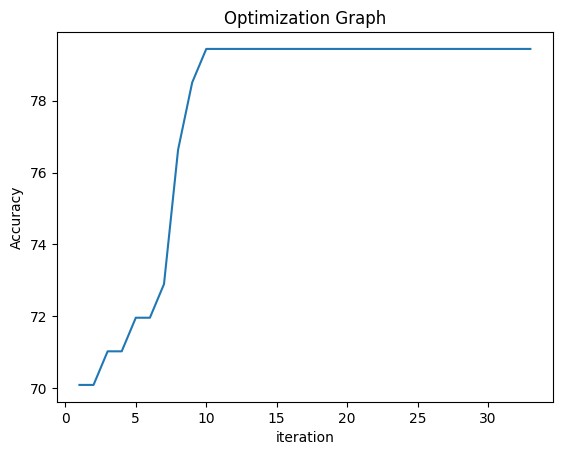

((21.06831547997036, 0.00021712608453969794), 79.43925233644859)

In [30]:
data1.train(n_particles=5, n_iter=250, w=0.5, c1=1, c2=1)

In [31]:
# data.optimation(np.arange(0,50,1), np.arange(0,1,0.1))

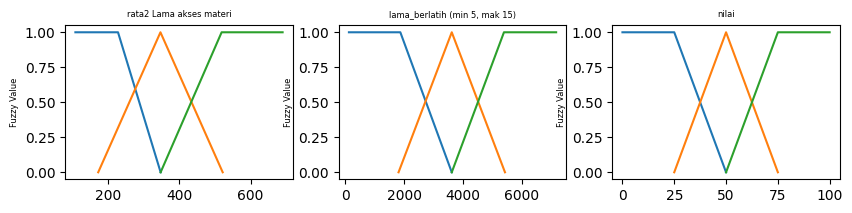

In [32]:
data.showFigure()
#7169 121

In [33]:
def make_domain2(min:int,max:int,amount:int,domain_width:float=0) -> list:
    """
    Fungsi make_domain digunakan untuk membuat domain fuzzy
    
    min : nilai minimum dari domain fuzzy
    max : nilai maksimum dari domain fuzzy
    amount: jumlah domain fuzzy yang akan dibuat
    domain_width : pergeseran domain fuzzy (default : 0.05)
    shifting yang digunakan yaitu (max-min)*domain_width
    
    """
    
    return [(min, int(max/2)), (int(max/4), int(int(max/2)+int(max/4))), (int(max/2), max)]
        

In [34]:
make_domain2(min=121, max=7179, amount=3)

[(121, 3589), (1794, 5383), (3589, 7179)]

In [35]:
data.df['lama_berlatih (min 5, mak 15)'].sum() / len(data.df['lama_berlatih (min 5, mak 15)'])

np.float64(924.3457943925233)

In [36]:
# data.bestFit

In [37]:
data.treshold = 22
data.domain_width = 0

data.Process()
data.showAccuracy()

C:\Users\Windows\AppData\Local\Temp\ipykernel_79532\4176031106.py:261: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(data == [rule[0], rule[1], rule[2]]):


79.43925233644859

In [38]:
data.predict()

['tidak lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'tidak lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'tidak lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'tidak lulus',
 'lulus',
 'tidak lulus',
 'tidak lulus',
 'lulus',
 'tidak lulus',
 'tidak lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'lulus',
 'tidak lulus',
 'tidak lulus',
 'tidak lulus',
 'tidak lulus',
 'tidak lulus',
 'tidak lulus',
 'tidak lulus',
 'tidak lulus',
 'tidak lulus',
 'tidak lulus',
 'tidak lulus',
 'tidak lulus',
 'tidak lulus',
 'tidak lulus',
 'tidak lulus',
 'tidak lulus',
 'tidak lulus',
 'lulus',
 'tidak lulus',
 'tidak lulus',
 'tidak lulus',
 'tidak lulus',
 'tidak lulus',
 'tidak lulus',
 'lulus',
 'tidak lulus',
 'tidak lulus',
 'lulus',
 'tidak lulus',
 'tidak lulus',


In [39]:
DFNew = pd.DataFrame(data.predict(), columns=['kesimpulannya'])

In [40]:
DFNew

,kesimpulannya
0,tidak lulus
1,lulus
2,lulus
3,lulus
4,lulus
...,...
102,lulus
103,tidak lulus
104,tidak lulus
105,tidak lulus
